<a href="https://colab.research.google.com/github/MMAMAR/stage-/blob/master/Revnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## data processing


In [3]:
!pip install netCDF4
import netCDF4
import numpy as np

from datetime import datetime,date
import matplotlib.pyplot as plt 
import os

     |████████████████████████████████| 4.1MB 4.9MB/s 
     |████████████████████████████████| 327kB 35.8MB/s 


In [0]:
#imports
import os
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.feature_extraction import image
from netCDF4 import Dataset
import numpy.ma as ma

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import requests

In [0]:
import os
os.chdir('/content/drive/My Drive')
import lap_diffusionMask
from scipy import interpolate

In [0]:
import scipy.fftpack as fftpack
from scipy import ndimage
def compute_PSD1D(I):

    W = np.reshape(np.hanning(I.shape[0]),(I.shape[0],1)) * np.reshape(np.hanning(I.shape[1]),(I.shape[1],1)).transpose() 

    F1 = fftpack.fft2( W * I) 
    F2 = fftpack.fftshift( F1 ) 
    psd2D = np.abs( F2 )**2
    
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2

    # create an array of integer radial distances from the center
    Y, X = np.ogrid[0:h, 0:w]
    r    = np.hypot(X - wc, Y - hc).astype(np.int)

    # SUM all psd2D pixels with label 'r' for 0<=r<=wc
    # NOTE: this will miss power contributions in 'corners' r>wc
    psd1D = ndimage.sum(psd2D, r, index=np.arange(0, wc))

    return psd1D


In [9]:

## test for filtering
filename = '/content/drive/My Drive/CMEMSData/global-analysis-forecast-phy-001-024-201901.nc'

## field info
SSHfieldname     = 'zos'
SSTfieldname     = 'thetao'
Latfieldname    = 'latitude'
Lonfieldname    = 'longitude'
Timefieldname   = 'time' 

        
print('..... Open monthly file: '+filename)
nc_fid = netCDF4.Dataset(filename,'r')

Lats=nc_fid[Latfieldname]
Lons=nc_fid[Lonfieldname]
sstfield = nc_fid['thetao'][:,0,:,:]
sstfield=sstfield[0]
sstfield=sstfield.reshape(241,601)
Lats=Lats[0:50]
Lons=Lons[0:50]

..... Open monthly file: /content/drive/My Drive/CMEMSData/global-analysis-forecast-phy-001-024-201901.nc


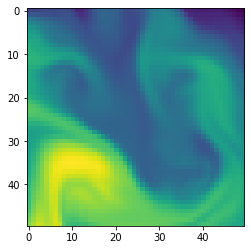

In [10]:
from sklearn.feature_extraction import image
X_patches=image.extract_patches_2d(sstfield, (50, 50), max_patches= 100, random_state=0)
Mask_patches=image.extract_patches_2d(sstfield.mask, (50, 50), max_patches= 100, random_state=0)

x_train=[]
maskes=[]

for i in range(len(X_patches)):
  if np.sum(Mask_patches[i]==True)==0:
    x_train.append(X_patches[i])
    maskes.append(Mask_patches[i])

plt.figure()
plt.imshow(x_train[0])
plt.show()

sstfield=x_train[0]

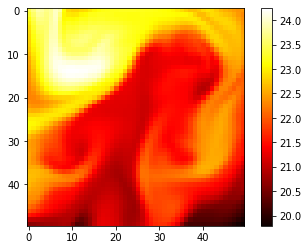

....... Filtering fine-scale for regridding


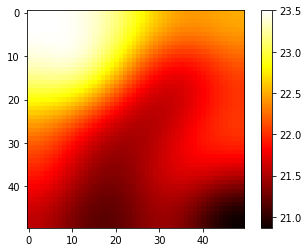

In [11]:
plt.figure(1)
imgplot=plt.imshow(np.flipud(sstfield))
imgplot.set_cmap('hot')
plt.colorbar()
plt.show()



print("....... Filtering fine-scale for regridding")
LamScale   = 0.2

IterScale  = 500
if IterScale > 0:
    sstFilt_HR = lap_diffusionMask.lap_diffusionMask(sstfield,IterScale,LamScale)
else:
    sstFilt_HR = sstfield.copy()



plt.figure(2)
imgplot=plt.imshow(np.flipud(sstFilt_HR))
imgplot.set_cmap('hot')
plt.colorbar()
plt.show()




In [12]:
res = 0.06
lat = np.arange(Lats[0],Lats[-1],res)
lon = np.arange(Lons[0],Lons[-1],res)

print("....... Regridding")
finterp = interpolate.interp2d(Lons,Lats,sstFilt_HR, kind='cubic')
sstHRi    = finterp(lon,lat)

....... Regridding


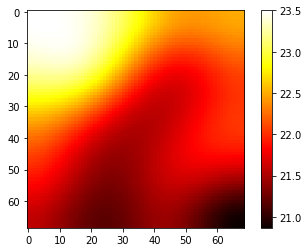

In [13]:
plt.figure()
imgplot=plt.imshow(np.flipud(sstHRi))
imgplot.set_cmap('hot')
plt.colorbar()
plt.show()


[6.39350469e+08 8.30758919e+08 6.23680918e+04 2.00159929e+04
 4.20043896e+03 1.61029495e+03 7.42582834e+02 3.89197039e+02
 2.22711834e+02 1.36019309e+02 8.73406286e+01 5.83455091e+01
 4.02354618e+01 2.84744609e+01 2.05836523e+01 1.51406053e+01
 1.13010192e+01 8.52623883e+00 6.49648152e+00 4.98177760e+00
 3.83833132e+00 2.96332387e+00 2.28895204e+00 1.76291114e+00
 1.35046998e+00 1.02512474e+00 7.67646377e-01 5.63688657e-01
 4.02518141e-01 2.76118346e-01 1.78406485e-01 1.04933496e-01
 5.24248798e-02 1.86206385e-02]


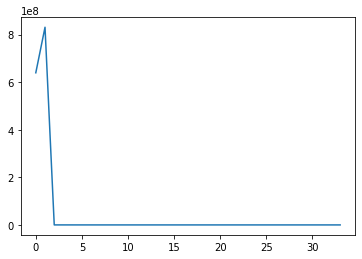

In [14]:
psd1D=compute_PSD1D(sstHRi)

plt.plot(np.arange(len(psd1D)),psd1D)

print(psd1D)


....... Low-pass filtering


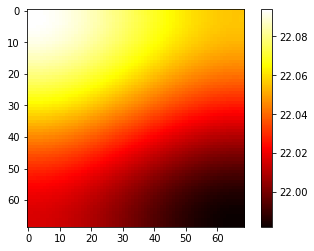

[-50. -49. -48. -47. -46.]


In [15]:
print("....... Low-pass filtering")
IterScale  = 100
sstLRi = lap_diffusionMask.lap_diffusionMask(sstHRi,IterScale,LamScale)

IterScale  = 100
if IterScale > 0 :
    resLR = 1.
    latLR = np.arange(Lats[0],Lats[-1],resLR)
    lonLR = np.arange(Lons[0],Lons[-1],resLR)
    finterp = interpolate.interp2d(lon,lat,sstLRi, kind='cubic')
    sstLRi  = finterp(lonLR,latLR)
    
    sstLRi = lap_diffusionMask.lap_diffusionMask(sstLRi,IterScale,LamScale)
    finterp = interpolate.interp2d(lonLR,latLR,sstLRi, kind='cubic')
    sstLRi  = finterp(lon,lat)



plt.figure()
imgplot=plt.imshow(np.flipud(sstLRi))
imgplot.set_cmap('hot')
plt.colorbar()
plt.show()
print(latLR)

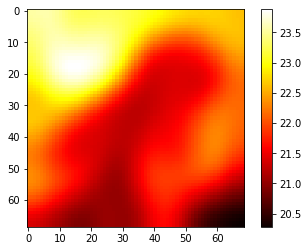

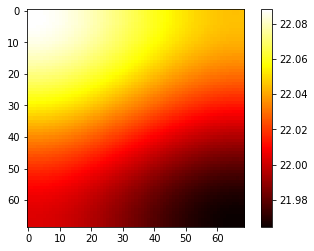

In [16]:
def GetHRData(I,IterScale,LamScale,res,Lats,Lons):
  #....... Filtering fine-scale for regridding

  if IterScale > 0:
    sstFilt_HR = lap_diffusionMask.lap_diffusionMask(I,IterScale,LamScale)
  else:
    sstFilt_HR = I.copy()

  
  lat = np.arange(Lats[0],Lats[-1],res)
  lon = np.arange(Lons[0],Lons[-1],res)

  #....... Regridding
  finterp = interpolate.interp2d(Lons,Lats,sstFilt_HR, kind='cubic')
  sstHRi    = finterp(lon,lat)

  return sstHRi

def GetLRData(I,IterScale,LamScale,res,resLR,Lats,Lons):
  sstLRi = lap_diffusionMask.lap_diffusionMask(I,IterScale,LamScale)
  if IterScale > 0 :
    lat = np.arange(Lats[0],Lats[-1],res)
    lon = np.arange(Lons[0],Lons[-1],res)
    latLR = np.arange(Lats[0],Lats[-1],resLR)
    lonLR = np.arange(Lons[0],Lons[-1],resLR)
    finterp = interpolate.interp2d(lon,lat,sstLRi, kind='cubic')
    sstLRi  = finterp(lonLR,latLR)
    
    sstLRi = lap_diffusionMask.lap_diffusionMask(sstLRi,IterScale,LamScale)
    finterp = interpolate.interp2d(lonLR,latLR,sstLRi, kind='cubic')
    sstLRi  = finterp(lon,lat)

  return sstLRi


sstHRii=GetHRData(sstfield,100,0.2,0.06,Lats,Lons)
plt.figure()
imgplot=plt.imshow(np.flipud(sstHRii))
imgplot.set_cmap('hot')
plt.colorbar()
plt.show()

sstLRii=GetLRData(sstHRii,100,0.2,0.06,1,Lats,Lons)
plt.figure()
imgplot=plt.imshow(np.flipud(sstLRii))
imgplot.set_cmap('hot')
plt.colorbar()
plt.show()


## Preprocessing 

In [0]:
import os
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.feature_extraction import image
from netCDF4 import Dataset
import numpy.ma as ma

In [18]:
os.chdir('/content/drive/My Drive/')
!pwd
!ls /content/drive/My\ Drive/CMEMSData

/content/drive/My Drive
global-analysis-forecast-phy-001-024-201810.nc
global-analysis-forecast-phy-001-024-201811.nc
global-analysis-forecast-phy-001-024-201812.nc
global-analysis-forecast-phy-001-024-201901.nc
global-analysis-forecast-phy-001-024-201902.nc
global-analysis-forecast-phy-001-024-201903.nc
global-analysis-forecast-phy-001-024-201904.nc


In [19]:
X_train=[]
Y_train=[]
X_test=[]
Y_test=[]
Maskes=[]
train_files=['global-analysis-forecast-phy-001-024-201812.nc','global-analysis-forecast-phy-001-024-201902.nc']
test_files=['global-analysis-forecast-phy-001-024-201901.nc']

# trainning data

for f in train_files:
  nc_data     = Dataset('./CMEMSData/'+f,'r')
  ssh = nc_data['zos'][:,:,:]
  sst = nc_data['thetao'][:,0,:,:]
  for i in range(len(sst)):
    X=np.flipud(sst[i,:,:]).data
    Y=np.flipud(ssh[i,:,:]).data
    XY_mask=np.flipud(ssh[i,:,:]).mask
    X_patches=image.extract_patches_2d(X, (50, 50), max_patches= 100, random_state=0)
    Y_patches=image.extract_patches_2d(Y, (50, 50), max_patches= 100, random_state=0)
    Mask_patches=image.extract_patches_2d(XY_mask, (50, 50), max_patches= 100, random_state=0)

    for j in range(len(X_patches)):
      X_train.append(X_patches[j])
      Y_train.append(Y_patches[j])
      Maskes.append(Mask_patches[j])

x_train=[]
y_train=[]

for i in range(len(X_train)):
  if np.sum(Maskes[i]==True)==0:
    x_train.append(X_train[i])
    y_train.append(Y_train[i])

print(len(x_train))
print(len(y_train))

#test data

Maskes=[]
for f in test_files:
  nc_data     = Dataset('./CMEMSData/'+f,'r')
  ssh = nc_data['zos'][:,:,:]
  sst = nc_data['thetao'][:,0,:,:]
  for i in range(len(sst)):
    X=np.flipud(sst[i,:,:]).data
    Y=np.flipud(ssh[i,:,:]).data
    XY_mask=np.flipud(ssh[i,:,:]).mask
    X_patches=image.extract_patches_2d(X, (50, 50), max_patches= 100, random_state=0)
    Y_patches=image.extract_patches_2d(Y, (50, 50), max_patches= 100, random_state=0)
    Mask_patches=image.extract_patches_2d(XY_mask, (50, 50), max_patches= 100, random_state=0)

    for j in range(len(X_patches)):
      X_test.append(X_patches[j])
      Y_test.append(Y_patches[j])
      Maskes.append(Mask_patches[j])

x_test=[]
y_test=[]

for i in range(len(X_test)):
  if np.sum(Maskes[i]==True)==0:
    x_test.append(X_test[i])
    y_test.append(Y_test[i])

print(len(x_test))
print(len(y_test))
X=[x_train,x_test]
Y=[y_train,y_test]
Mx1=np.array([np.mean(x) for x in x_train]).mean()
My1=np.array([np.mean(y) for y in y_train]).mean()
Mx2=np.array([np.mean(x) for x in x_test]).mean()
My2=np.array([np.mean(y) for y in y_test]).mean()
print(Mx1)
print(My1)
print(Mx2)
print(My2)

#Moyenne non spacialisée

x_train=np.array(x_train)
y_train=np.array(y_train)
x_test=np.array(x_test)
y_test=np.array(y_test)

x_train=x_train-Mx1
y_train=y_train-My1
x_test=x_test-Mx2
y_test=y_test-My2


x_train,y_train=shuffle(x_train,y_train, random_state=0)
x_test,y_test=shuffle(x_test,y_test, random_state=0)

"""
x_train=torch.Tensor(x_train)
y_train=torch.Tensor(y_train)
x_test=torch.Tensor(x_test)
y_test=torch.Tensor(y_test)
"""

5605
5605
2945
2945
15.594807103916969
0.0060345840484668225
15.615132012611205
0.02577029756980937


'\nx_train=torch.Tensor(x_train)\ny_train=torch.Tensor(y_train)\nx_test=torch.Tensor(x_test)\ny_test=torch.Tensor(y_test)\n'

In [20]:
X_train=[]
Y_train=[]
X_test=[]
Y_test=[]

for i in range(len(x_train)):
  x=GetHRData(x_train[i],100,0.2,0.06,Lats,Lons)
  X_train.append([x,x])
  y=GetHRData(y_train[i],100,0.2,0.06,Lats,Lons)
  Y_train.append([y,y])
print("...............done")
  

for i in range(len(x_test)):
  x=GetHRData(x_test[i],100,0.2,0.06,Lats,Lons)
  X_test.append([x,x])
  y=GetHRData(y_test[i],100,0.2,0.06,Lats,Lons)
  Y_test.append([y,y])
print("...............done")


...............done
...............done


In [21]:
print(np.array(X_train).shape)
print(np.array(Y_train).shape)
print(np.array(X_test).shape)
print(np.array(Y_test).shape)


(5605, 2, 69, 69)
(5605, 2, 69, 69)
(2945, 2, 69, 69)
(2945, 2, 69, 69)


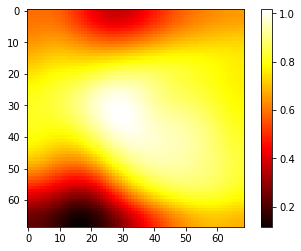

In [22]:
plt.figure()
imgplot=plt.imshow(Y_test[0][0])
imgplot.set_cmap('hot')
plt.colorbar()
plt.show()

In [0]:
del x_train, y_train, x_test, y_test, X_patches, Y_patches, Mask_patches


In [0]:
X_train=torch.Tensor(X_train)/10
Y_train=torch.Tensor(Y_train)/2
X_test=torch.Tensor(X_test)/10
Y_test=torch.Tensor(Y_test)/2

## Revnet Model

In [0]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Function, Variable

CUDA = torch.cuda.is_available()

def size_after_residual(size, out_channels, kernel_size, stride, padding, dilation):
    """Calculate the size of the output of the residual function
    """
    N, C_in, H_in, W_in = size

    H_out = math.floor(
        (H_in + 2*padding - dilation*(kernel_size - 1) - 1) / stride + 1
    )
    W_out = math.floor(
        (W_in + 2*padding - dilation*(kernel_size - 1) - 1) / stride + 1
    )
    return N, out_channels, H_out, W_out


def possible_downsample(x, in_channels, out_channels, stride=1, padding=1,
                        dilation=1):
    _, _, H_in, W_in = x.size()

    _, _, H_out, W_out = size_after_residual(x.size(), out_channels, 3, stride, padding, dilation)

    # Downsample image
    if H_in > H_out or W_in > W_out:
        out = F.avg_pool2d(x, 2*dilation+1, stride, padding)

    # Pad with empty channels
    if in_channels < out_channels:

        try: out
        except: out = x

        pad = Variable(torch.zeros(
            out.size(0),
            (out_channels - in_channels) // 2,
            out.size(2), out.size(3)
        ), requires_grad=True)
        """
        if CUDA:
            pad = pad.cuda()
         """
        temp = torch.cat([pad, out], dim=1)
        out = torch.cat([temp, pad], dim=1)

    # If we did nothing, add zero tensor, so the output of this function
    # depends on the input in the graph
    try: out
    except:
        injection = Variable(torch.zeros_like(x.data), requires_grad=True)

        if CUDA:
            injection.cuda()

        out = x + injection

    return out


class RevBlockFunction(Function):
    @staticmethod
    def residual(x, in_channels, out_channels, params, buffers, training,
                 stride=1, padding=1, dilation=1, no_activation=False):
        """Compute a pre-activation residual function.
        Args:
            x (Variable): The input variable
            in_channels (int): Number of channels of x
            out_channels (int): Number of channels of the output
        Returns:
            out (Variable): The result of the computation
        """
        out = x

        if not no_activation:
            out = F.batch_norm(out, buffers[0], buffers[1], params[0],
                               params[1], training)
            out = F.relu(out)

        out = F.conv2d(out, params[-6], params[-5], stride, padding=padding,
                       dilation=dilation)

        out = F.batch_norm(out, buffers[-2], buffers[-1], params[-4],
                           params[-3], training)
        out = F.relu(out)
        out = F.conv2d(out, params[-2], params[-1], stride=1, padding=1,
                       dilation=1)

        return out

    @staticmethod
    def _forward(x, in_channels, out_channels, training, stride, padding,
                 dilation, f_params, f_buffs, g_params, g_buffs,
                 no_activation=False):

        x1, x2 = torch.chunk(x, 2, dim=1)

        with torch.no_grad():
            x1 = Variable(x1.contiguous())
            x2 = Variable(x2.contiguous())

            if CUDA:
                x1.cuda()
                x2.cuda()

            x1_ = possible_downsample(x1, in_channels, out_channels, stride,
                                      padding, dilation)
            x2_ = possible_downsample(x2, in_channels, out_channels, stride,
                                      padding, dilation)

            f_x2 = RevBlockFunction.residual(
                x2,
                in_channels,
                out_channels,
                f_params,
                f_buffs, training,
                stride=stride,
                padding=padding,
                dilation=dilation,
                no_activation=no_activation
            )

            y1 = f_x2 + x1_

            g_y1 = RevBlockFunction.residual(
                y1,
                out_channels,
                out_channels,
                g_params,
                g_buffs,
                training
            )

            y2 = g_y1 + x2_

            y = torch.cat([y1, y2], dim=1)

            del y1, y2
            del x1, x2

        return y

    @staticmethod
    def _backward(output, in_channels, out_channels, f_params, f_buffs,
                  g_params, g_buffs, training, padding, dilation, no_activation):

        y1, y2 = torch.chunk(output, 2, dim=1)
        with torch.no_grad():
            y1 = Variable(y1.contiguous())
            y2 = Variable(y2.contiguous())

            x2 = y2 - RevBlockFunction.residual(
                y1,
                out_channels,
                out_channels,
                g_params,
                g_buffs,
                training=training
            )

            x1 = y1 - RevBlockFunction.residual(
                x2,
                in_channels,
                out_channels,
                f_params,
                f_buffs,
                training=training,
                padding=padding,
                dilation=dilation
            )

            del y1, y2
            x1, x2 = x1.data, x2.data

            x = torch.cat((x1, x2), 1)
        return x

    @staticmethod
    def _grad(x, dy, in_channels, out_channels, training, stride, padding,
              dilation, activations, f_params, f_buffs, g_params, g_buffs,
              no_activation=False, storage_hooks=[]):
        dy1, dy2 = torch.chunk(dy, 2, dim=1)

        x1, x2 = torch.chunk(x, 2, dim=1)

        with torch.enable_grad():
            x1 = Variable(x1.contiguous(), requires_grad=True)
            x2 = Variable(x2.contiguous(), requires_grad=True)
            x1.retain_grad()
            x2.retain_grad()

            if CUDA:
                x1.cuda()
                x2.cuda()

            x1_ = possible_downsample(x1, in_channels, out_channels, stride,
                                      padding, dilation)
            x2_ = possible_downsample(x2, in_channels, out_channels, stride,
                                      padding, dilation)

            f_x2 = RevBlockFunction.residual(
                x2,
                in_channels,
                out_channels,
                f_params,
                f_buffs,
                training=training,
                stride=stride,
                padding=padding,
                dilation=dilation,
                no_activation=no_activation
            )

            y1_ = f_x2 + x1_

            g_y1 = RevBlockFunction.residual(
                y1_,
                out_channels,
                out_channels,
                g_params,
                g_buffs,
                training=training
            )

            y2_ = g_y1 + x2_

            dd1 = torch.autograd.grad(y2_, (y1_,) + tuple(g_params), dy2,
                                      retain_graph=True)
            dy2_y1 = dd1[0]
            dgw = dd1[1:]
            dy1_plus = dy2_y1 + dy1
            dd2 = torch.autograd.grad(y1_, (x1, x2) + tuple(f_params), dy1_plus,
                                      retain_graph=True)
            dfw = dd2[2:]

            dx2 = dd2[1]
            dx2 += torch.autograd.grad(x2_, x2, dy2, retain_graph=True)[0]
            dx1 = dd2[0]

            for hook in storage_hooks:
                x = hook(x)

            activations.append(x)

            y1_.detach_()
            y2_.detach_()
            del y1_, y2_
            dx = torch.cat((dx1, dx2), 1)

        return dx, dfw, dgw

    @staticmethod
    def forward(ctx, x, in_channels, out_channels, training, stride, padding,
                dilation, no_activation, activations, storage_hooks, *args):
        """Compute forward pass including boilerplate code.
        This should not be called directly, use the apply method of this class.
        Args:
            ctx (Context):                  Context object, see PyTorch docs
            x (Tensor):                     4D input tensor
            in_channels (int):              Number of channels on input
            out_channels (int):             Number of channels on output
            training (bool):                Whethere we are training right now
            stride (int):       
                        Stride to use for convolutions
            no_activation (bool):           Whether to compute an initial
                                            activation in the residual function
            activations (List):             Activation stack
            storage_hooks (List[Function]): Functions to apply to activations
                                            before storing them
            *args:                          Should contain all the Parameters
                                            of the module
        """

        if not no_activation:
            f_params = [Variable(x) for x in args[:8]]
            g_params = [Variable(x) for x in args[8:16]]
            f_buffs = args[16:20]
            g_buffs = args[20:]
        else:
            f_params = [Variable(x) for x in args[:6]]
            g_params = [Variable(x) for x in args[6:14]]
            f_buffs = args[14:16]
            g_buffs = args[16:]

        if CUDA:
            for var in f_params:
                var.cuda()
            for var in g_params:
                var.cuda()

        # if the images get smaller information is lost and we need to save the input
        _, _, H_in, W_in = x.size()
        _, _, H_out, W_out = size_after_residual(x.size(), out_channels, 3, stride, padding, dilation)
        if H_in > H_out or W_in > W_out or no_activation:
            activations.append(x)
            ctx.load_input = True
        else:
            ctx.load_input = False

        ctx.save_for_backward(*[x.data for x in f_params],
                              *[x.data for x in g_params])
        ctx.f_buffs = f_buffs
        ctx.g_buffs = g_buffs
        ctx.stride = stride
        ctx.padding = padding
        ctx.dilation = dilation
        ctx.training = training
        ctx.no_activation = no_activation
        ctx.storage_hooks = storage_hooks
        ctx.activations = activations
        ctx.in_channels = in_channels
        ctx.out_channels = out_channels

        y = RevBlockFunction._forward(
            x,
            in_channels,
            out_channels,
            training,
            stride,
            padding,
            dilation,
            f_params, f_buffs,
            g_params, g_buffs,
            no_activation=no_activation
        )

        return y.data

    @staticmethod
    def backward(ctx, grad_out):
        saved_tensors = list(ctx.saved_tensors)
        if not ctx.no_activation:
            f_params = [Variable(p, requires_grad=True) for p in saved_tensors[:8]]
            g_params = [Variable(p, requires_grad=True) for p in saved_tensors[8:16]]
        else: 
            f_params = [Variable(p, requires_grad=True) for p in saved_tensors[:6]]
            g_params = [Variable(p, requires_grad=True) for p in saved_tensors[6:14]]

        in_channels = ctx.in_channels
        out_channels = ctx.out_channels

        # Load or reconstruct input
        if ctx.load_input:
            ctx.activations.pop()
            x = ctx.activations.pop()
        else:
            output = ctx.activations.pop()
            x = RevBlockFunction._backward(
                output,
                in_channels,
                out_channels,
                f_params, ctx.f_buffs,
                g_params, ctx.g_buffs,
                ctx.training,
                ctx.padding,
                ctx.dilation,
                ctx.no_activation
            )

        dx, dfw, dgw = RevBlockFunction._grad(
            x,
            grad_out,
            in_channels,
            out_channels,
            ctx.training,
            ctx.stride,
            ctx.padding,
            ctx.dilation,
            ctx.activations,
            f_params, ctx.f_buffs,
            g_params, ctx.g_buffs,
            no_activation=ctx.no_activation,
            storage_hooks=ctx.storage_hooks
        )

        num_buffs = 2 if ctx.no_activation else 4

        return ((dx, None, None, None, None, None, None, None, None, None) + tuple(dfw) +
                tuple(dgw) + tuple([None]*num_buffs) + tuple([None]*4))


class RevBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activations, stride=1,
                 padding=1, dilation=1, no_activation=False, storage_hooks=[]):
        super(RevBlock, self).__init__()

        self.in_channels = in_channels // 2
        self.out_channels = out_channels // 2
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.no_activation = no_activation
        self.activations = activations
        self.storage_hooks = storage_hooks

        if not no_activation:
            self.register_parameter(
                'f_bw1',
                nn.Parameter(torch.Tensor(self.in_channels))
            )
            self.register_parameter(
                'f_bb1',
                nn.Parameter(torch.Tensor(self.in_channels))
            )

        self.register_parameter(
            'f_w1',
            nn.Parameter(torch.Tensor(
                self.out_channels,
                self.in_channels,
                3, 3
            ))
        )
        self.register_parameter(
            'f_b1',
            nn.Parameter(torch.Tensor(self.out_channels))
        )
        self.register_parameter(
            'f_bw2',
            nn.Parameter(torch.Tensor(self.out_channels))
        )
        self.register_parameter(
            'f_bb2',
            nn.Parameter(torch.Tensor(self.out_channels))
        )
        self.register_parameter(
            'f_w2',
            nn.Parameter(torch.Tensor(
                self.out_channels,
                self.out_channels,
                3, 3
            ))
        )
        self.register_parameter(
            'f_b2',
            nn.Parameter(torch.Tensor(self.out_channels))
        )

        self.register_parameter(
            'g_bw1',
            nn.Parameter(torch.Tensor(self.out_channels))
        )
        self.register_parameter(
            'g_bb1',
            nn.Parameter(torch.Tensor(self.out_channels))
        )
        self.register_parameter(
            'g_w1',
            nn.Parameter(torch.Tensor(
                self.out_channels,
                self.out_channels,
                3, 3
            ))
        )
        self.register_parameter(
            'g_b1',
            nn.Parameter(torch.Tensor(self.out_channels))
        )
        self.register_parameter(
            'g_bw2',
            nn.Parameter(torch.Tensor(self.out_channels))
        )
        self.register_parameter(
            'g_bb2',
            nn.Parameter(torch.Tensor(self.out_channels))
        )
        self.register_parameter(
            'g_w2',
            nn.Parameter(torch.Tensor(
                self.out_channels,
                self.out_channels,
                3, 3
            ))
        )
        self.register_parameter(
            'g_b2',
            nn.Parameter(torch.Tensor(self.out_channels))
        )

        if not no_activation:
            self.register_buffer('f_rm1', torch.zeros(self.in_channels))
            self.register_buffer('f_rv1', torch.ones(self.in_channels))
        self.register_buffer('f_rm2', torch.zeros(self.out_channels))
        self.register_buffer('f_rv2', torch.ones(self.out_channels))

        self.register_buffer('g_rm1', torch.zeros(self.out_channels))
        self.register_buffer('g_rv1', torch.ones(self.out_channels))
        self.register_buffer('g_rm2', torch.zeros(self.out_channels))
        self.register_buffer('g_rv2', torch.ones(self.out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        f_stdv = 1 / math.sqrt(self.in_channels * 3 * 3)
        g_stdv = 1 / math.sqrt(self.out_channels * 3 * 3)

        if not self.no_activation:
            self._parameters['f_bw1'].data.uniform_()
            self._parameters['f_bb1'].data.zero_()
        self._parameters['f_w1'].data.uniform_(-f_stdv, f_stdv)
        self._parameters['f_b1'].data.uniform_(-f_stdv, f_stdv)
        self._parameters['f_w2'].data.uniform_(-g_stdv, g_stdv)
        self._parameters['f_b2'].data.uniform_(-g_stdv, g_stdv)
        self._parameters['f_bw2'].data.uniform_()
        self._parameters['f_bb2'].data.zero_()

        self._parameters['g_w1'].data.uniform_(-g_stdv, g_stdv)
        self._parameters['g_b1'].data.uniform_(-g_stdv, g_stdv)
        self._parameters['g_w2'].data.uniform_(-g_stdv, g_stdv)
        self._parameters['g_b2'].data.uniform_(-g_stdv, g_stdv)
        self._parameters['g_bw1'].data.uniform_()
        self._parameters['g_bb1'].data.zero_()
        self._parameters['g_bw2'].data.uniform_()
        self._parameters['g_bb2'].data.zero_()

        if not self.no_activation:
            self._buffers['f_rm1'].zero_()
            self._buffers['f_rv1'].fill_(1)
        self.f_rm2.zero_()
        self.f_rv2.fill_(1)

        self.g_rm1.zero_()
        self.g_rv1.fill_(1)
        self.g_rm2.zero_()
        self.g_rv2.fill_(1)

    def forward(self, x):
        return RevBlockFunction.apply(
            x,
            self.in_channels,
            self.out_channels,
            self.training,
            self.stride,
            self.padding,
            self.dilation,
            self.no_activation,
            self.activations,
            self.storage_hooks,
            *self._parameters.values(),
            *self._buffers.values(),
        )


class RevNet(nn.Module):
    def __init__(self,
                 units,
                 filters,
                 strides,
                 bottleneck=False):
        """
        Args:
            units (list-like): Number of residual units in each group
            filters (list-like): Number of filters in each unit including the
                inputlayer, so it is one item longer than units
            strides (list-like): Strides to use for the first units in each
                group, same length as units
            bottleneck (boolean): Wether to use the bottleneck residual or the
                basic residual
        """
        super(RevNet, self).__init__()
        self.name = self.__class__.__name__

        self.activations = []

        if bottleneck:
            self.Reversible = RevBottleneck     # TODO: Implement RevBottleneck
        else:
            self.Reversible = RevBlock

        self.layers = nn.ModuleList()
        """
        # Input layer
        self.layers.append(nn.Conv2d(3, filters[0], 3, padding=1))
        self.layers.append(nn.BatchNorm2d(filters[0]))
        """
        for i, group_i in enumerate(units):
            self.layers.append(self.Reversible(
                filters[i], filters[i + 1],
                stride=strides[i],
                no_activation=True,
                activations=self.activations
            ))

            for unit in range(1, group_i):
                self.layers.append(self.Reversible(
                    filters[i + 1],
                    filters[i + 1],
                    activations=self.activations
                ))

        #self.fc = nn.Linear(filters[-1], classes)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        # Save last output for backward
        self.activations.append(x.data)
        """
        x = F.avg_pool2d(x, x.size(2))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        """

        return x

    def free(self):
        """Clear saved activation residue and thereby free memory."""
        del self.activations[:]

In [30]:
x = X_train[0].view(1,2,69,69)
model = RevBlock(2,2, [])
parameters = list(model._parameters.values())
buffers = list(model._buffers.values())
# self.f_params = [Variable(x) for x in parameters[:8]]
# self.g_params = [Variable(x) for x in parameters[8:16]]
f_param = parameters[:8]
g_param = parameters[8:16]
f_buff = buffers[:4]
g_buff = buffers[4:8]
in_channels = model.in_channels
out_channels = model.out_channels
training = model.training
stride = model.stride
no_activ= model.no_activation

print(f_param)

[Parameter containing:
tensor([0.1016], requires_grad=True), Parameter containing:
tensor([0.], requires_grad=True), Parameter containing:
tensor([[[[-0.1493, -0.2831, -0.1556],
          [ 0.2539,  0.2035, -0.2165],
          [ 0.1047,  0.1235,  0.0392]]]], requires_grad=True), Parameter containing:
tensor([0.0971], requires_grad=True), Parameter containing:
tensor([0.2978], requires_grad=True), Parameter containing:
tensor([0.], requires_grad=True), Parameter containing:
tensor([[[[-0.1109,  0.2205, -0.0428],
          [-0.1075,  0.1676,  0.1489],
          [-0.0785, -0.0878,  0.3104]]]], requires_grad=True), Parameter containing:
tensor([-0.1549], requires_grad=True)]


In [31]:
y = RevBlockFunction._forward(x,in_channels,
                              out_channels,training,
                              stride, padding=1,dilation=1,
                              f_params=f_param,f_buffs=f_buff,
                              g_params=g_param, g_buffs=g_buff,
                              no_activation=no_activ)
print(y.size())

torch.Size([1, 2, 69, 69])


In [33]:
 z = RevBlockFunction._backward(
            y.data,
            in_channels,
            out_channels,
            padding=1,dilation=1,
            f_params=f_param, f_buffs=f_buff,
            g_params=g_param, g_buffs=g_buff,
            training=training,
            no_activation=no_activ
        )
 print(z-x)

tensor([[[[ 0.0000e+00, -5.9605e-08,  0.0000e+00,  ...,  0.0000e+00,
           -1.1921e-07,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           -5.9605e-08, -5.9605e-08],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00, -1.1921e-07],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00, -1.1921e-07],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
     

## training the model

In [0]:
model = RevNet(
            units=[32,32,32],
            filters=[2, 2, 2, 2],
            strides=[1, 1, 1]
            )

In [0]:
lossfunction=nn.MSELoss()
optimizer=optim.Adam(model.parameters(), lr=0.00001)

In [69]:
epochs= 20
batch_size= 500

for i in range(epochs):
  #running_loss=0 
  for j in range(0,len(X_train), batch_size):
    X = X_train[j:j+batch_size].view(-1, 2, 69, 69)
    Y = Y_train[j:j+batch_size].view(-1, 2, 69, 69)
    if CUDA:
      model.cuda()
      X=Variable(X.cuda())
      Y=Variable(Y.cuda())
    optimizer.zero_grad()
    outputs = model(X)
    loss = lossfunction(outputs, Y)
    loss.backward()
    optimizer.step()
    #running_loss+=loss.item()

    if j==5000:
      print("epoch=",i,"; running_loss=", loss.item())

epoch= 0 ; running_loss= 7.549257755279541
epoch= 1 ; running_loss= 7.345979690551758
epoch= 2 ; running_loss= 7.150378704071045
epoch= 3 ; running_loss= 6.9618072509765625
epoch= 4 ; running_loss= 6.780416011810303
epoch= 5 ; running_loss= 6.605658054351807
epoch= 6 ; running_loss= 6.43751859664917
epoch= 7 ; running_loss= 6.2765421867370605
epoch= 8 ; running_loss= 6.121992111206055
epoch= 9 ; running_loss= 5.974196910858154
epoch= 10 ; running_loss= 5.833167552947998
epoch= 11 ; running_loss= 5.697700023651123
epoch= 12 ; running_loss= 5.56724214553833
epoch= 13 ; running_loss= 5.441283702850342
epoch= 14 ; running_loss= 5.31949520111084
epoch= 15 ; running_loss= 5.2014241218566895
epoch= 16 ; running_loss= 5.086554050445557
epoch= 17 ; running_loss= 4.9745283126831055
epoch= 18 ; running_loss= 4.865401268005371
epoch= 19 ; running_loss= 4.758962631225586


In [0]:
outputs=model.forward(Variable(X_test[0:100].cuda()))

In [78]:
outputs.shape

torch.Size([100, 2, 69, 69])

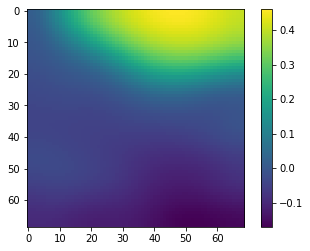

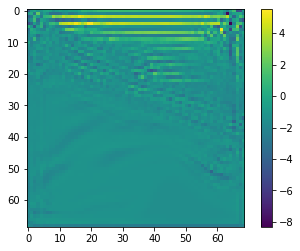

In [90]:
i=43
plt.figure()
imgplot=plt.imshow(Y_test[i][0])
plt.colorbar()
plt.show()

plt.figure()
imgplot=plt.imshow(outputs.data[i][0].cpu().detach().numpy())
plt.colorbar()
plt.show()